In [33]:
from __future__ import print_function, division
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline

# Observed Galxy Colors

In [34]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolshoi', halo_finder='rockstar', redshift=0, version_name='halotools_v0p4')

In [35]:
from halotools.empirical_models import HodModelFactory

# define the central occupation model
from halotools.empirical_models import TrivialPhaseSpace, Cacciato09Cens
cens_occ_model =  Cacciato09Cens(prim_haloprop_key = 'halo_mvir', threshold = 9.0)
cens_prof_model = TrivialPhaseSpace()

# define the satellite occupation model
from halotools.empirical_models import Cacciato09Sats
from halotools.empirical_models import NFWPhaseSpace, SubhaloPhaseSpace
sats_occ_model =  Cacciato09Sats(prim_haloprop_key = 'halo_mvir', threshold = 9.0)
sats_occ_model._suppress_repeated_param_warning = True
sats_prof_model = NFWPhaseSpace()

# convert luminosity to magnitude
from occupation_model_components import MagnitudesSDSS
central_mag_model = MagnitudesSDSS(gal_type='centrals')
satellite_mag_model = MagnitudesSDSS(gal_type='satellites')

# define quenching model
from halotools.empirical_models import ZuMandelbaum16QuenchingCens, ZuMandelbaum16QuenchingSats
cens_quenching_model = ZuMandelbaum16QuenchingCens(prim_haloprop_key = 'halo_mvir')
sats_quenching_model = ZuMandelbaum16QuenchingSats(prim_haloprop_key = 'halo_mvir')

cens_quenching_model.param_dict['quenching_mass_centrals'] = 10**12.5
cens_quenching_model.param_dict['quenching_exp_power_centrals'] = 0.8
#sats_quenching_model.param_dict['quenching_exp_power_satellites']=0.001
#cens_quenching_model.param_dict['quenching_mass_satellites'] = 10**100.0

# define morphology model
from morphology_model_components import Morphology_1 as Morphology
cens_morpholopgy_model = Morphology(gal_type='centrals')
sats_morpholopgy_model = Morphology(gal_type='satellites')

# define shape model
from shape_model_components import PS08Shapes, EllipticalGalaxyShapes, DiskGalaxyShapes
cens_elliptical_shape_model = EllipticalGalaxyShapes(gal_type='centrals')
cens_disk_shape_model       = DiskGalaxyShapes(gal_type='centrals')
sats_elliptical_shape_model = EllipticalGalaxyShapes(gal_type='satellites')
sats_disk_shape_model       = DiskGalaxyShapes(gal_type='satellites')

# define alignment model
from intrinsic_alignments.ia_models.ia_model_components import RandomAlignment
central_orientation_model = RandomAlignment(gal_type='centrals')
satellite_orientation_model = RandomAlignment(gal_type='satellites')

# projected shapes
from shape_model_components import ProjectedShapes
central_proj_shapes_model = ProjectedShapes('centrals')
satellite_proj_shapes_model = ProjectedShapes('satellites')

# extinction model
from extinction_model_components import Shao07DustExtinction
central_extinction_model = Shao07DustExtinction(gal_type='centrals')
satellite_extinction_model = Shao07DustExtinction(gal_type='satellites')

# color model
from color_model_components import GalaxyColor
central_color_model = GalaxyColor(gal_type='centrals')
satellite_color_model = GalaxyColor(gal_type='satellites')

# combine model components
model_instance = HodModelFactory(centrals_occupation = cens_occ_model,
                                 centrals_profile = cens_prof_model,
                                 centrals_mag_model = central_mag_model,
                                 satellites_mag_model = satellite_mag_model,
                                 satellites_occupation = sats_occ_model,
                                 satellites_profile = sats_prof_model,
                                 centrals_quenching = cens_quenching_model,
                                 satellites_quenching = sats_quenching_model,
                                 centrals_morphology = cens_morpholopgy_model,
                                 satellites_morphology = sats_morpholopgy_model,
                                 centrals_elliptical_galaxy_shape = cens_elliptical_shape_model,
                                 centrals_disk_galaxy_shape = cens_disk_shape_model,
                                 satellites_elliptical_galaxy_shape = sats_elliptical_shape_model,
                                 satellites_disk_galaxy_shape = sats_disk_shape_model,
                                 centrals_orientation = central_orientation_model,
                                 satellites_orientation = satellite_orientation_model,
                                 centrals_proj_shapes = central_proj_shapes_model,
                                 satellites_proj_shapes = satellite_proj_shapes_model,
                                 centrals_color_model = central_color_model,
                                 satellites_color_model = satellite_color_model,
                                 centrals_extinction_model = central_extinction_model,
                                 satellites_extinction_model = satellite_extinction_model,
                                 model_feature_calling_sequence = (
                                 'centrals_occupation',
                                 'centrals_profile',
                                 'satellites_occupation',
                                 'satellites_profile',
                                 'centrals_mag_model',
                                 'satellites_mag_model',
                                 'centrals_quenching',
                                 'satellites_quenching',
                                 'centrals_morphology',
                                 'satellites_morphology',
                                 'centrals_elliptical_galaxy_shape',
                                 'centrals_disk_galaxy_shape',
                                 'satellites_elliptical_galaxy_shape',
                                 'satellites_disk_galaxy_shape',
                                 'centrals_orientation',
                                 'satellites_orientation',
                                 'centrals_proj_shapes',
                                 'satellites_proj_shapes',
                                 'centrals_color_model',
                                 'satellites_color_model',
                                 'centrals_extinction_model',
                                 'satellites_extinction_model',)
                                )

In [36]:
# populate mock catalog
model_instance.populate_mock(halocat)
mock = model_instance.mock.galaxy_table

N_gal = len(mock)
print("number of galaxies: ", N_gal)

f_sat = 1.0*np.sum(mock['gal_type']=='satellites')/N_gal
print("satellite fraction: ", f_sat)

f_quiescent = 1.0*np.sum(mock['quiescent']==True)/N_gal
print("quiescent fraction: ", f_quiescent)

number of galaxies:  542661
satellite fraction:  0.272064880284
quiescent fraction:  0.347974149607


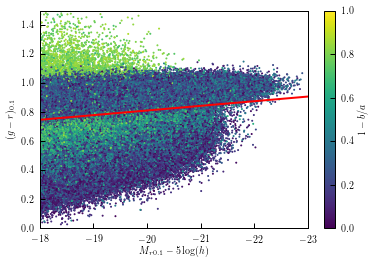

In [37]:
def red_blue_split(mag_r, h=1):
    """
    see eq. 1 in Weinmann + 2006
    """
    return 0.7 - 0.032*(mag_r - 5.0*np.log10(h) + 16.5)

observed_mag = mock['Mag_r'] + mock['deltaMag_r']
observed_color = mock['galaxy_g_minus_r'] + (mock['deltaMag_g']-mock['deltaMag_r'])
e = 1.0 - mock['galaxy_projected_b_to_a']

m_sample = np.linspace(-24,-17,1000)[::-1]

plt.figure()
plt.scatter(observed_mag, observed_color,
            c=e, s=1, alpha=1, vmin=0, vmax=1)
plt.plot(m_sample, red_blue_split(m_sample), '-', color='red', lw=2)
plt.ylim([0,1.5])
plt.xlim([-18,-23])
plt.xlabel(r'$M_{r0.1}-5\log(h)$')
plt.ylabel(r'$(g-r)_{0.1}$')
plt.colorbar(label=r'$1-b/a$')
plt.show()

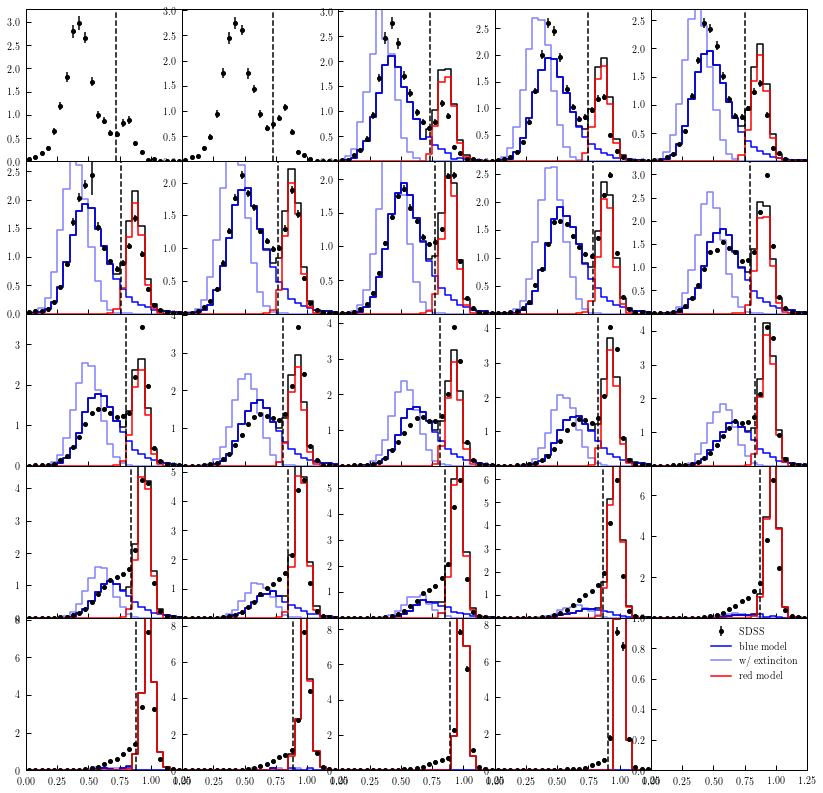

In [38]:
mag_bins = np.arange(-24.00, -16.99, 0.25)[::-1]
mag_bin_centers = (mag_bins[:-1]+mag_bins[1:])/2.0
N_mag_bins = len(mag_bins)-1

color_bins = np.arange(0,1.5001,0.05)
color_bin_centers = (color_bins[:-1]+color_bins[1:])/2.0

observed_color = mock['galaxy_g_minus_r'] + (mock['deltaMag_g']-mock['deltaMag_r'])
intrinsic_color = mock['galaxy_g_minus_r']

observed_mag = mock['Mag_r'] + mock['deltaMag_r']
intrinsic_mag = mock['Mag_r']

# row and column sharing
fig, axes = plt.subplots(5, 5, sharex=True, sharey=False, figsize=(14.0,14.0))
axes = axes.flatten()
plt.subplots_adjust(wspace=0, hspace=0)

N = len(mag_bins)-1
m1s = np.zeros(N)
m2s = np.zeros(N)
s1s = np.zeros(N)
s2s = np.zeros(N)
fs = np.zeros(N)
for i in range(0,25-1):
    
    ax = axes[i]
    
    # load sdss measurement
    t = Table.read('../sdss_measurements/data/sample_'+str(int(i))+'_g_minus_r.dat', format='ascii')
    
    # plot sdss distribution
    x0 = t['g_minus_r']
    y0 = t['frequency']
    y0_err = t['err']
    p1 = ax.errorbar(x0,y0,y0_err,fmt='o', ms=4, color='black')
    
    # caclulate mock distribution
    mask = (intrinsic_mag<mag_bins[i]) & (intrinsic_mag>mag_bins[i+1])
    N = np.sum(mask)
    
    # full distribution
    counts_0 = np.histogram(observed_color[mask], bins=color_bins)[0]
    counts = 1.0*counts_0/np.sum(counts_0)/np.diff(color_bins)
    ax.step(color_bins[:-1], counts, where='post', color='black')
    
    # blue
    counts = np.histogram(observed_color[mask & mock['disk']], bins=color_bins)[0]
    counts_b1 = 1.0*counts/np.sum(counts_0)/np.diff(color_bins)
    ax = axes[i]
    l1, = ax.step(color_bins[:-1], counts_b1, where='post', color='blue')
    
    counts = np.histogram(intrinsic_color[mask & mock['disk']], bins=color_bins)[0]
    counts_b2 = 1.0*counts/np.sum(counts_0)/np.diff(color_bins)
    ax = axes[i]
    l2, = ax.step(color_bins[:-1], counts_b2, where='post', color='blue', alpha=0.5)
    
    # red
    counts = np.histogram(observed_color[mask & mock['elliptical']], bins=color_bins)[0]
    counts_r = 1.0*counts/np.sum(counts_0)/np.diff(color_bins)
    ax = axes[i]
    l3, = ax.step(color_bins[:-1], counts_r, where='post', color='red')
    
    # empirical diuvision
    c = red_blue_split(mag_bin_centers[i])
    ax.plot([c,c],[0,10], '--', color='black')
    
    ax.set_ylim([0,1.1*np.max(y0)])

ax = axes[24]
ax.legend([p1,l1,l2,l3], ['SDSS', 'blue model', 'w/ extinciton', 'red model'], frameon=False)

ax.set_xlim([0,1.25])
plt.show()

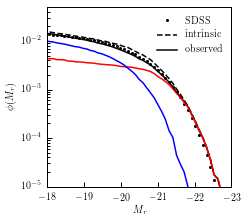

In [39]:
from lss_observations.luminosity_functions import Blanton_2003_phi

phi = Blanton_2003_phi()

mag_r = mock['Mag_r']
obs_mag_r = mag_r + mock['deltaMag_r']

bins = np.linspace(-24,-17.8,62)
bin_centers = (bins[:-1]+bins[1:])/2.0

counts_1 = np.histogram(mag_r, bins=bins)[0]
counts_1 = counts_1/np.prod(halocat.Lbox)/np.diff(bins)

counts_2 = np.histogram(obs_mag_r, bins=bins)[0]
counts_2 = counts_2/np.prod(halocat.Lbox)/np.diff(bins)

mask = (mock['quiescent']==True)
counts_3= np.histogram(mag_r[mask], bins=bins)[0]
counts_3 = counts_3/np.prod(halocat.Lbox)/np.diff(bins)

mask = (mock['quiescent']==False)
counts_4= np.histogram(obs_mag_r[mask], bins=bins)[0]
counts_4 = counts_4/np.prod(halocat.Lbox)/np.diff(bins)

plt.figure(figsize=(3.3,3.3))
l0, = plt.plot(bin_centers, phi(bin_centers), 'o', color='black', ms=2)
l1, = plt.plot(bin_centers, counts_1, '--', color='black')
l2, = plt.plot(bin_centers, counts_2, '-', color='black')
l3, = plt.plot(bin_centers, counts_3, '-', color='red')
l4, = plt.plot(bin_centers, counts_4, '-', color='blue')
plt.legend([l0,l1,l2],['SDSS','intrinsic','observed'],
            frameon=False, loc='upper right', fontsize=10)
plt.ylabel(r'$\phi(M_r)$')
plt.xlabel(r'$M_r$')
plt.ylim([10**-5,0.05])
plt.xlim([-18,-23])
plt.yscale('log')
plt.show()

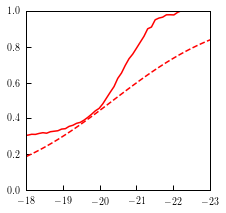

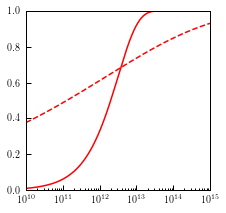

In [42]:
from galaxy_shapes.shape_models.color_model_components import GalaxyColor, BinaryGalaxyColor
blue_fraction = BinaryGalaxyColor()
blue_fraction = blue_fraction.blue_fraction

f_red = counts_3/counts_2

plt.figure(figsize=(3.3,3.3))
plt.plot(bin_centers, f_red, '-', color='red')
plt.plot(bin_centers, 1-blue_fraction(bin_centers), '--', color='red')
plt.xlim([-18,-23])
plt.ylim([0,1])
plt.show()


m_sample = np.logspace(10,15,1000)
f_red_sat = sats_quenching_model.mean_quiescent_fraction(prim_haloprop=m_sample)
f_red_cen = cens_quenching_model.mean_quiescent_fraction(prim_haloprop=m_sample)

plt.figure(figsize=(3.3,3.3))
plt.plot(m_sample, f_red_sat, '--', color='red')
plt.plot(m_sample, f_red_cen, '-', color='red')
plt.xlim([10**10,10**15])
plt.ylim([0,1])
plt.xscale('log')
plt.show()

## fitting for extincted color distribution 

In [ ]:
l = 7.1765
k = 1.0/(sigma*7.1765)

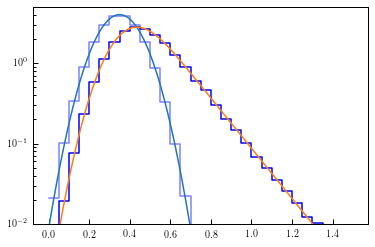

In [108]:
counts_0 = np.histogram(color_0, bins = color_bins)[0]
counts_0 = 1.0*counts_0/np.sum(counts_0)/np.diff(color_bins)
counts_1 = np.histogram(color_1, bins = color_bins)[0]
counts_1 = 1.0*counts_1/np.sum(counts_1)/np.diff(color_bins)

x_sample = np.linspace(0,1.5,1000)

plt.figure()
plt.step(color_bins[:-1], counts_0, where='post', color='blue', alpha=0.5)
plt.step(color_bins[:-1], counts_1, where='post', color='blue')
loc = color_model.param_dict['color_mu_1']
scale = color_model.param_dict['color_sigma_1']
plt.plot(x_sample, norm.pdf(x_sample, loc, scale))
plt.plot(x_sample, model_pdf(x_sample, loc, scale))

plt.yscale('log')
plt.ylim([0.01,5])
plt.show()

In [107]:
def model_pdf(x, loc, scale):
    """
    """
    k = 1.0/(scale*7.1765)
    return exponnorm.pdf(x, k, loc, scale)